# Machine Learning with NeuroTechUofT

Welcome to the notebook for [NeurotechUofT](https://neurotechuoft.com/)'s introduction to applied machine learning for neurotechnology. This notebook encompasses material that will be introduced as part of the machine learning segment of NeuroTechUofT's intermediate workshops.


## Setup
Here we will import some required packages that we will use throughout this workshop and define some helper functions that will make the workshop a lot more streamlined.

In [ ]:
!pip install -q "tqdm"

In [ ]:
import sklearn.linear_model
import sklearn.datasets
import sklearn.neighbors
import sklearn.neural_network
import sklearn.tree
import sklearn.svm
import sklearn.discriminant_analysis
import sklearn.cluster
import sklearn.decomposition
import sklearn.ensemble
import sklearn.pipeline
import sklearn.preprocessing
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

import tqdm
import graphviz

In [ ]:
plt.style.use('ggplot')

In [ ]:
# Setting the seed for reproducability
np.random.seed(0)

We will use the following two functions to visualize our data and learned functions in two dimensions.

In [ ]:
def visualize_regression_data(data, axis=None, **kwargs):
  """Visualize two-dimensional data points.

  Arguments
    <data>: ? x 2 array of real data to be visualized
    <axis>: axis on which to plot data, if not provided one is constructed
    <kwargs>: other keyword arguments are passed to the matplotlib `plot` function

  Returns
    matplotlib axis object on which data was plotted
  """
  data = np.array(data)
  if axis is None:
    axis = plt.subplot()

  axis.plot(data[:, 0], data[:, 1], "o", **kwargs)

  return axis

def visualize_func(f, axis=None, *, num_samples=101, domain=(0, 1), **kwargs):
  """Visualize a real-to-real function.

  Arguments
    <f>: the real-to-real function to be visualized
    <axis>: axis on which to plot data, if not provided one is constructed
    <num_samples>: number of points to sample from <f>
    <domain>: domain from which to sample from <f>
    <kwargs>: other keyword arguments are passed to the matplotlib `plot` function
  
  Returns
    matplotlib axis object on which function was plotted
  """
  if axis is None:
    axis = plt.subplot()

  xs = np.linspace(*domain, num_samples)
  axis.plot(xs, f(xs), **kwargs)

  return axis

def visualize_classification_data(X, y, axis=None, **kwargs):
  """Visualize two-dimensional classification data points.

  Arguments
    <X>: ? x 2 array of real data to be visualized
    <y>: ? array of classification labels for the data
    <axis>: axis on which to plot data, if not provided one is constructed
    <kwargs>: other keyword arguments are passed to the matplotlib `scatter` function

  Returns
    matplotlib axis object on which data was plotted
  """
  X, y = np.array(X), np.array(y)
  if axis is None:
    axis = plt.subplot()

  axis.scatter(X[:, 0], X[:, 1], c=y, cmap="Paired")

  return axis
  
def visualize_classifier(clf, X, axis=None, *, mesh_step_size=0.01, **kwargs):
  """Visualize a two-dimensional classifier.

  Arguments
    <clf>: the classifier to be visualized
    <X>: data the classifier was trained on, used to calculate bounds
    <axis>: axis on which to plot data, if not provided one is constructed
    <mesh_step_size>: step size in the mesh grid to visualize
    <kwargs>: other keyword arguments are passed to the matplotlib `contourf` function
  
  Returns
    matplotlib axis object on which function was plotted
  """
  X = np.array(X)
  if axis is None:
    axis = plt.subplot()

  x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
  y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
  xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size),
                       np.arange(y_min, y_max, mesh_step_size))
  
  axis.set_xlim(xx.min(), xx.max())
  axis.set_ylim(yy.min(), yy.max())

  if hasattr(clf, "decision_function"):
      Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
  elif hasattr(clf, "predict_proba"):
      Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
  else:
      Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  axis.contourf(xx, yy, Z, cmap="viridis", alpha=0.75)

  return axis

def visualize_clustering_data(X, axis=None, **kwargs):
  """Visualize two-dimensional clustering data points.

  Arguments
    <X>: ? x 2 array of real data to be visualized
    <axis>: axis on which to plot data, if not provided one is constructed
    <kwargs>: other keyword arguments are passed to the matplotlib `scatter` function

  Returns
    matplotlib axis object on which data was plotted
  """
  X = np.array(X)
  if axis is None:
    axis = plt.subplot()

  axis.scatter(X[:, 0], X[:, 1], cmap="Paired")

  return axis
  
def visualize_clusterer(clf, X, axis=None, **kwargs):
  """Visualize a two-dimensional clusterer.

  Arguments
    <clf>: the clusterer to be visualized
    <X>: data the clusterer should be visualized on
    <axis>: axis on which to plot data, if not provided one is constructed
    <kwargs>: other keyword arguments are passed to the matplotlib `scatter` function
  
  Returns
    matplotlib axis object on which function was plotted
  """
  X = np.array(X)
  if axis is None:
    axis = plt.subplot()

  y = clf.predict(X)
  axis.scatter(X[:, 0], X[:, 1], c=y, cmap="Paired")

  return axis

## NumPy

Brief intro...

### Warmup

Before we dive into implementing all these cool ML algorithms, we need to get acquainted with a fundemental package for scientific computation in Python. NumPy is an incredibly popular Python package that allows us to manipulate multidimensional arrays quickly, easily, and most importantly efficiently. NumPy offloads many time-consuming operations to highly-optimized low-level C code while providing very high-level interfaces to do all types of scientific computing with these multidimensional arrays.

To begin, we will learn how to use basic NumPy functionalities such as matrix algebra and sampling from distributions.

In [ ]:
# Above, we have imported `numpy` as `np`.
# We will use the alias `np` to refer to `numpy` in the code.

# NumPy's building block is the `np.ndarray` which is an n-dimensional array.
# We can easily transform between Python lists and NumPy arrays.
lst = [[1, 2, 3], [4, 5, 6]]
arr = np.array(lst)
print("\nlist to array\n", arr)

# Using Python lists to construct NumPy arrays can be very inefficient,
# instead we will do most our work directly in NumPy.
# There are many ways to construct NumPy arrays outside of `np.array`, 
# we will demonstrate some common ones here.

# Constructing arrays of ones and zeros is quite easy.
print("\nones\n", np.ones((2, 2)))
print("\nzeros\n", np.zeros((3, 3)))
# Constructing linearly spaced one-dimensional arrays is also straightforward.
print("\nlinspace\n", np.linspace(0, 1, 5))
# Diagonal and identity matricies are a breeze.
print("\neye (identity)\n", np.eye(3))
print("\ndiag\n", np.diag([1., 2., 3.]))
# Random arrays are exposed too (we will talk more about sampling later).
print("\nrand\n", np.random.rand(2, 2))


list to array
 [[1 2 3]
 [4 5 6]]

ones
 [[1. 1.]
 [1. 1.]]

zeros
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

linspace
 [0.   0.25 0.5  0.75 1.  ]

eye (identity)
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

diag
 [[1. 0. 0.]
 [0. 2. 0.]
 [0. 0. 3.]]

rand
 [[0.5488135  0.71518937]
 [0.60276338 0.54488318]]


In [ ]:
# After constructing arrays, we can start doing optimized algebra with them.
arr = np.random.rand(2, 2)
print("\narr\n", arr)

# We can do all basic Python operations.
arr + 2
arr - 2
arr * 2
arr ** 2
arr / 2
arr // 2
arr % 2

# Note that NumPy automatically "broadcasts" operations; that is,
# when something like `arr + 2` is done, the `2` is converted to a shape
# compatible with `arr`. This is why `arr + 2` makes sense to add `2` to every
# element in `arr`.

# We can also use some built-in scientific methods that will come in handy.

# Computing element-wise exponential and logarithm with base {e}.
np.exp(arr)
np.log(arr)

# Summing over a collection of axis in the array.
print("\nsum (axis=1)\n", np.sum(arr, 1))
print("\nsum (axis=0)\n", np.sum(arr, 0))
print("\nsum (axis=(0, 1))\n", np.sum(arr, (0, 1)))

# There are a whole lot more functions that we will not go through.
# The only proper way to get exposed to all the things NumPy can do, 
# is to use it!


arr
 [[0.4236548  0.64589411]
 [0.43758721 0.891773  ]]

sum (axis=1)
 [1.06954891 1.32936021]

sum (axis=0)
 [0.86124201 1.53766711]

sum (axis=(0, 1))
 2.3989091244503333


In [ ]:
# In this example, we will implement the popular sigmoid function in NumPy.

def sigmoid(x):
  """Computes the element-wise sigmoid over an array.
  
  Sigmoid is defined by the function {s(x) := 1 / (1 + exp(-x))}.

  Arguments
    <x>: data to take the element-wise sigmoid over.

  Returns
    {s(x)} where {s} is the sigmoid function.
  """
  s = 1 / (1 + np.exp(-x))  # TODO
  return s


# To test that the implementation of sigmoid is correct, 
# we will run it through its inverse and verify that it computes the identity.

def logit(x):
  """Computes the element-wise logit over an array.

  Logit is defined by the function {l(x) := ln(x / (1 - x))}.

  Arguments
    <x>: data to take the element-wise logit over.

  Returns
    {l(x)} where {l} is the logit function.
  """
  l = np.log(x / (1 - x))
  return l

test_arr = np.random.rand(2, 2)
assert np.isclose(test_arr, logit(sigmoid(test_arr))).all()

### Generating 2D Regression Data

Now that we have a grip on how to use NumPy in general, we are going to start generating some data we can use for our machine learning algorithms, particularly regression. We have provided some visualization functions in the setup code above, it would be a good time to get familiar with how to use those functions in order to visualize your data. We also provide some examples below.

In [ ]:
# We are going to write a function that generates some noisy data based on a
# given function as a trend for that data.

def gendata(f, num_samples, *, domain=(0, 1), noise=0.1):
  """Generate noisy data on a given trend.
  
  Arguments
    <f>: data trend represented by a function from reals to reals
    <num_samples>: number of samples to take from <f>
    <domain>: domain on which to sample data from <f>
    <noise>: magnitude of noise applied to samples from <f>

  Returns
    <num_samples> x 2 array of floats representing the generated samples.
  """
  # Sample <num_samples> uniform samples from <domain>
  # and evaluate <f> on those samples
  xs = np.random.uniform(*domain, size=num_samples)  # TODO
  ys = f(xs)  # TODO

  # Perturb the samples using Gaussian noise with scale <noise>
  noisy_ys = np.random.normal(ys, noise)  # TODO

  # Arrange the data in the expected return format
  data = np.stack((xs, noisy_ys), axis=1)
  return data


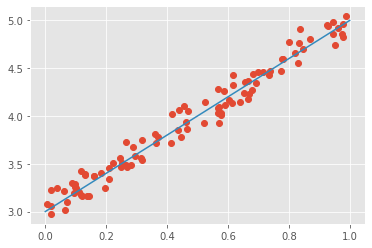

In [ ]:
# To validate your `gendata` function, we provide some starter code that samples
# 100 data points from a linear function and plots both the function and the data. 

# Construct a linear function {f(x) := 2x + 3}
# and sample 100 data points from it
linear = lambda x: 2 * x + 3
data = gendata(linear, 100)

# Visualize the data and the linear function on the same axis
axis = visualize_regression_data(data)
axis = visualize_func(linear, axis=axis)
plt.show()

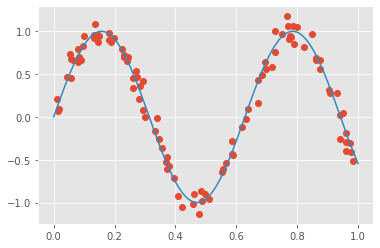

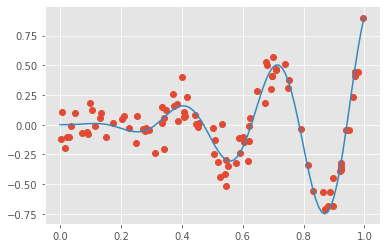

In [ ]:
# We now want to play around with different functions to get the hang of it all!

# Construct a sinusoidal function {f(x) := sin(10 * x)}
# and sample 100 data points from it
sinusoidal = lambda x: np.sin(10 * x)  # TODO
data = gendata(sinusoidal, 100)  # TODO

# Visualize the data and the sinusoidal function on the same axis
axis = visualize_regression_data(data)
axis = visualize_func(sinusoidal, axis=axis)
plt.show()


# Construct a function {f(x) := x^2 * sin(10 * x)}
# and sample 100 data points from it
func = lambda x: (x ** 2) * np.sin(20 * x)  # TODO
data = gendata(func, 100)  # TODO

# Visualize the data and the function on the same axis
axis = visualize_regression_data(data)
axis = visualize_func(func, axis=axis)
plt.show()

In practice, we would not have access to the underlying function generating the data points we would like to fit a function to (we would only have the red dots, not the blue curve). However, for our purposes, we are generating the data we will train on as pedagogical examples.

Now that we have a method of generating data points, let us explore one of the simpler methods of trying to figure out the generating function of these data points (trying to go from the red dots to the blue curve).

## 2D Linear Regression

In this section, we will implement a linear regression model and go over different optimization techniques to construct a linear fit to our data. Much of the math that we will work with here is explained in the lecture slides, we will focus on the implementation using NumPy in this notebook.

The typical single-dimensional linear regression model consists of two parameters: the weight and the bias which we will respectively denote $w$ and $b$ where both $w, b \in \mathbb{R}$. Our linear regression model output would look like $f(x) := wx + b$. The goal will be to find assignments of $w$ and $b$ that make $f(x)$ look as close as possible to the underlying function generating our dataset $\mathcal{D} = (X, Y)$ where both $X, Y \subseteq \mathbb{R}$.

### Model

We will first build up our model by constructing two functions: `initialize_model` to initialize the weight and bias for our single-dimensional linear regression model, and `run_model` that will take in the weight and bias of the single-dimensional linear regression model as well as inputs and produce the computed model outputs.

In [ ]:
def initialize_model():
  """Initializes the weights and biases for our linear regression model.
  
  Returns
    tuple of weight parameter and bias parameter
  """
  # Sample the weight from a standard normal distribution
  weight = np.random.randn()  # TODO
  # Initialize the bias to zero
  bias = 0  # TODO 

  return weight, bias

def run_model(xs, weight, bias):
  """Run a model on some input data.

  Arguments
    <xs>: length N array of input data
    <weight>: weight of the linear regression model
    <bias>: bias of the linear regression model
  
  Returns
    length N array of predicted outputs
  """
  # Compute the linear function
  output = weight * xs + bias  # TODO

  return output

Now to use the above functions to see how our model might look if run on unoptimized parameters (i.e. we just want to initialize the weights then see what it predicts). We should expect this to be quite bad since it has not been fit to our data whatsoever.

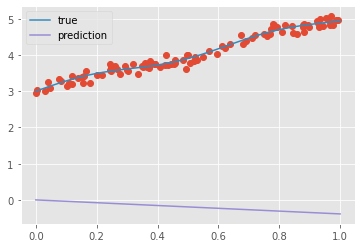

In [ ]:
kinda_linear = lambda x: 2 * x + 3 + 0.1 * np.sin(10 * x)
data = gendata(kinda_linear, 100)

# Initalize the model and construct a function to compute it on samples
init_weight, init_bias = initialize_model()  # TODO
random_model = lambda x: run_model(x, init_weight, init_bias)  # TODO

axis = visualize_regression_data(data)
axis = visualize_func(kinda_linear, axis=axis, label="true")
axis = visualize_func(random_model, axis=axis, label="prediction")
plt.legend()
plt.show()

Now, let's try hand-tuning the parameters (weight and bias) by choosing a weight and bias for the linear regression model that makes sense based on the visualized data.

We can think of this process as the manual, heuristic version of what our computers would do when we try to optimize our parameters to fit the data. We should end up with a linear model that fits quite nicely to the trend of the data.

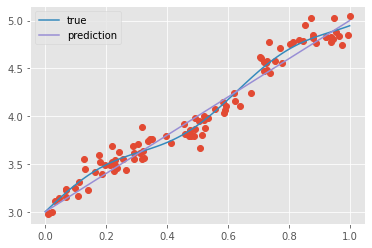

In [ ]:
data = gendata(kinda_linear, 100)

# Manually find a weight and bias that visually work with the data
weight = 2  # TODO
bias = 3  # TODO
hand_tuned_model = lambda x: run_model(x, weight, bias)

axis = visualize_regression_data(data)
axis = visualize_func(kinda_linear, axis=axis, label="true")
axis = visualize_func(hand_tuned_model, axis=axis, label="prediction")
plt.legend()
plt.show()

### Automatic Fitting
Trying to optimize the parameters of our models by hand can get very tedious and eventually practically impossible when we are talking about very high-dimensional data and parameter spaces. We would like to find a way to tune and fit these parameters to our data automatically.

Tuning our model parameters consists of two major components: the objective we are trying to optimize towards and the methodology or process of optimization.

To some extend, our objective wants to reflect how close the function computed by our model is to the underlying data-generating function; we typically achieve this by considering how well the function computed by the model fits to the data points we have (since we do not have access to the underlying data-generating function). For example, in a model trying to learn to predict whether someone is thinking about food through EEG signals we might have the objective be the proportion of times the model correctly determines whether or not the person is thinking of food. Naturally, we would like to optimize this objective such that this proportion is as high as possible.

The chosen process of optimization can also differ greatly. Most optimization techniques nowadays use some variant of "gradient descent" in which the opimizer follows the objective function to try and minimize it with respect to the parameters. We will discuss gradient descent in more detail later in this notebook.

#### Objective Functions
As a matter of convention, we typically treat our objective functions as functions we would like to *minimize* instead of maximize. This, however, is quite simple since maximizing a function $f$ is the same as minimizing the function $-f$.

So, based on our previous example, our objective would be the proportion of times that our model does not correctly determine whether or not the person is thinking of food. We would like to minimize that proportion.

The objective function chosen for a given problem is completely up to the designer of the ML algorithm that is tasked with solving that problem; naturally, better formulations of an objective function will tend to produce better-performing models.

In this section, we will explore two typical objective functions that approach the problem quite differently; however, it ends up that both objective functions are essentially equivalent.

##### Maximum Likelihood Estimation

Maximum likelihood estimation defines the objective function in a probabalistic light, typically revolving around a normal (Gaussian) distribution. Instead of assuming that our model output is exact, we treat it as the mean of a normal distribution with a preset variance that we decide on. Then, a measure of how bad the prediction $\hat{y}$ is can simply be formulated as the negative likelihood of the true sample $y$ coming out of the constructed distribution $\mathcal{N}(\hat{y}, \sigma^2)$.

We generally take the negative log likelihood instead of the negative likelihood to minimize to make factorization easier, and since the log is a monotonically increasing function we know it will not impact optimization.

In [ ]:
def negative_log_likelihood(preds, targets, *, scale=1):
  """Computes the negative log likelihood of predictions.

  We will use a factorized Gaussian distribution centered around each target
  value with a constant scale as the distribution with respect to which we would
  like to compute the likelihood of the predictions.

  Arguments
    <preds>: length N array of predictions
    <targets>: length N array of target data
    <scale>: standard deviation for the Gaussian distribution
  
  Returns
    log likelihood of predictions with respect to target distribution
  """
  # Take the negative log likelihood of our targets with respect 
  # to the generated normal distribution centered around the predictions
  # HINT: use `scipy.stats.norm.logpdf`
  nll = -scipy.stats.norm.logpdf(targets, preds, scale)  # TODO
  return np.mean(nll)

In [ ]:
print(negative_log_likelihood(random_model(data[:, 0]), data[:, 1]))
print(negative_log_likelihood(hand_tuned_model(data[:, 0]), data[:, 1]))

9.939365043790861
0.9266833520450899


##### Least Squares
A possibly more natural formulation of a typical objective function for a regression problem is simply how different our prediction $\hat{y}$ is from our target $y$.

Widely used is the mean squared error, which is simply what the name states: it is the mean of the squared error (or difference) between every pair of corresponding targets and predictions.

In [ ]:
def mean_squared_error(preds, targets):
  """Computes the mean squared error of predictions.

  Arguments
    <preds>: length N array of predictions
    <targets>: length N array of target data

  Returns
    mean squared error of predictions from target
  """
  # Compute the mean squared error of the predictions from the targets
  mse = np.mean((targets - preds) ** 2)  # TODO
  return mse

In [ ]:
print(mean_squared_error(random_model(data[:, 0]), data[:, 1]))
print(mean_squared_error(hand_tuned_model(data[:, 0]), data[:, 1]))

18.040853021172378
0.01548963768083489


#### Optimization Methods
There are a whole lot of different methods of optimizing functions (in this case minimizing our objective function with respect to the model parameters). Here, we will focus on a fundemental technique called gradient descent or GD for short.

GD follows the gradient of our objective function to try and find its minimum, simply taking steps in the direction of the negative gradient to find the minimum of the function. GD can often get stuck in local minima, where all the negative gradients point towards the point it is already at; there are more advanced techniques that build upon GD that try to solve this problem and others.

Before we dive into GD, we will talk about direct solutions to the minimization problem as inspiration.

##### Direct Solution
A direct solution to the optimization problem is just that, we manually analytically derive the point at which the objective function is minimized with respect to the model parameters.

Choose your favorite objective function from the two above, take its derivatives with respect to the model weight and model bias, set those derivatives and set each of those derivatives to zero to find the weight and bias that minimize the function. Then translate those formulae to NumPy and see how your direct solution performs on our toy dataset.

In [ ]:
def direct_solution(data):
  """Compute the direct solution of the linear regression model.

  Arguments
    <data>: N x 2 array of input and target data

  Returns
    tuple of direct solution weight parameter and bias parameter
  """
  inputs = data[:, 0]
  targets = data[:, 1]

  # Compute the mean of inputs and targets as helper variables
  input_mean = np.mean(inputs)  # TODO
  target_mean = np.mean(targets)  # TODO

  # Calculate the analytically solved weight value
  numerator = np.sum((inputs - input_mean) * (targets - target_mean))  # TODO
  denominator = np.sum((inputs - input_mean) ** 2)  # TODO
  weight = numerator / denominator  # TODO

  # Calculate the analytically solved bias value
  bias = target_mean - weight * input_mean  # TODO

  return weight, bias

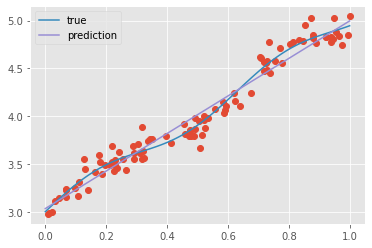

0.926521487534443
0.015165908659540712


In [ ]:
# Get the direct solution weight and bias and construct a model based on them
direct_weight, direct_bias = direct_solution(data)  # TODO
direct_solution_model = lambda x: run_model(x, direct_weight, direct_bias)  # TODO

axis = visualize_regression_data(data)
axis = visualize_func(kinda_linear, axis=axis, label="true")
axis = visualize_func(direct_solution_model, axis=axis, label="prediction")
plt.legend()
plt.show()

print(negative_log_likelihood(direct_solution_model(data[:, 0]), data[:, 1]))
print(mean_squared_error(direct_solution_model(data[:, 0]), data[:, 1]))

You should see quite a good fit of the data!

##### Gradient Descent
Trying to analytically solve every optimization problem can get quite difficult, GD affords us a technique to empirically solve many optimization problems by way of following the objective function's gradient.

Here we implement a stock GD procedure to empirically optimize our linear regression model. We will focus on working with the mean squared error objective function since that is typically simpler to take derivatives of.

In [ ]:
def gradient(data, weight, bias):
  """Compute the gradient of the mean squared error.

  Compute the partial derivatives of the mean squared error with respect to both
  the weight and the bias parameter.

  Arguments
    <data>: N x 2 array of input and target data
    <weight>: weight of the linear regression model
    <bias>: bias of the linear regression model

  Returns
    tuple of derivatives of mean squared error with respect to weight and bias
  """
  inputs = data[:, 0]
  targets = data[:, 1]
  preds = run_model(inputs, weight, bias)

  # Compute the derivatives of the mean squared error
  # with respect to the model weight
  deriv_weight = 2 * np.mean((preds - targets) * inputs)  # TODO
  # and with respect to the model bias
  deriv_bias = 2 * np.mean(preds - targets)  # TODO

  return deriv_weight, deriv_bias

In [ ]:
def gd_solution(data, *, num_iterations=10000, learning_rate=0.01):
  """Optimize the weight and bias of our model using gradient descent.

  Arguments
    <data>: N x 2 array of input and target data
    <num_iterations>: number of iterations of gradient descent to perform
    <learning_rate>: learning rate of the gradient descent optimizer

  Returns
      tuple of optimized weight parameter and bias parameter
  """
  # Initialize the model weight and bias to anything
  # HINT: use `initialize_model`
  weight, bias = initialize_model()  # TODO

  for _ in tqdm.trange(num_iterations):
    # Get the current derivative of the weight and bias
    deriv_weight, deriv_bias = gradient(data, weight, bias)  # TODO
    # Compute the new weight and bias based on the learning rate and the
    # derivatives, remember that we step in the direction of the negative 
    # gradient multiplied by the learning rate
    weight -= learning_rate * deriv_weight  # TODO
    bias -= learning_rate * deriv_bias  # TODO

  return weight, bias

100%|██████████| 10000/10000 [00:00<00:00, 37941.67it/s]


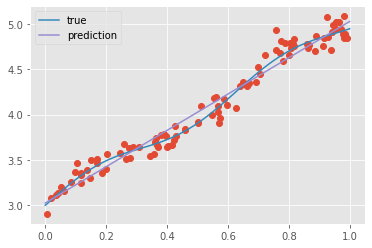

0.925707795087212
0.013538523765078485


In [ ]:
data = gendata(kinda_linear, 100)

# Get the GD solution weight and bias and construct a model based on them
gd_weight, gd_bias = gd_solution(data)  # TODO
gd_model = lambda x: run_model(x, gd_weight, gd_bias)  # TODO

axis = visualize_regression_data(data)
axis = visualize_func(kinda_linear, axis=axis, label="true")
axis = visualize_func(gd_model, axis=axis, label="prediction")
plt.legend()
plt.show()

print(negative_log_likelihood(gd_model(data[:, 0]), data[:, 1]))
print(mean_squared_error(gd_model(data[:, 0]), data[:, 1]))

You should see quite a good fit of the data!

Now let us try our amazing linear regression model optimized by our GD procedure on some data that is less linear.

100%|██████████| 10000/10000 [00:00<00:00, 35236.45it/s]


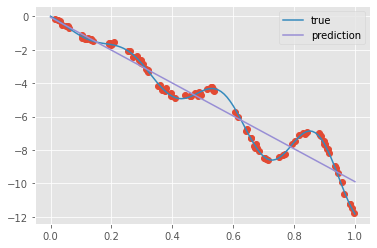

1.259188039612443
0.680499012815541


In [ ]:
func = lambda x: -2 * x * np.sin(20 * x) - 10 * x
data = gendata(func, 100)

# Get the GD solution weight and bias and construct a model based on them
gd_weight, gd_bias = gd_solution(data)  # TODO
gd_model = lambda x: run_model(x, gd_weight, gd_bias)  # TODO

axis = visualize_regression_data(data)
axis = visualize_func(func, axis=axis, label="true")
axis = visualize_func(gd_model, axis=axis, label="prediction")
plt.legend()
plt.show()

print(negative_log_likelihood(gd_model(data[:, 0]), data[:, 1]))
print(mean_squared_error(gd_model(data[:, 0]), data[:, 1]))

Well, it doesn't look *too* bad. But it seems that we have found a limitation of our linear regression model: it is **linear** (shocker)! Much of the data we encounter in the real world will not be very linear, so linear regression models will have limited applicability; however, the concepts they describe and introduce will be incredibly important when learning to use more advanced ML techniques. 

### Using Scikit Learn



Now that we have the basics of linear regression down, let's start using some libraries to generalize the functionality (recall that our implementation only works on two-dimensional data!)

Typically, mature libraries have many optimizations and built-in features that can be utilized to make development of ML models more efficient that trying to implement everything from scratch. Although it is helpful to learn how to implementing things, when trying to develop an actual application do not try to reinvent the wheel unless you have a solid case to do so.

We are going to learn the basics of how to do linear regression with a popular Python machine learning library called [Scikit Learn](https://scikit-learn.org/stable/). This isn't one of those deep learning libraries like PyTorch or TensorFlow, instead it is one focused on general machine learning. Scikit learn provides a whole lot of different modules to do different types of machine learning including classification, clustering, dimensionality reduction, and even preprocessing; however, we will focus on linear regression here.

We are going to be using [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) to develop our linear regression model, and, if we implemented our custom linear regression correctly, we should achieve similar regression performance. It will be helpful to skim through the API linked above to learn the basics of how to use the `LinearRegression` object.

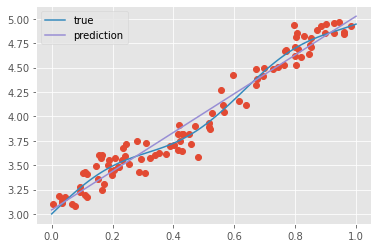

0.9270548199135535
0.01623257341776199


In [ ]:
# Construct the linear regression model (untrained)
# NOTE: keep the initialization parameters at their defaults
# Use `sklearn.linear_model.LinearRegression`
sklearn_model = sklearn.linear_model.LinearRegression()  # TODO

# Generate a data sample
data = gendata(kinda_linear, 100)

# Fit the constructed linear regression model to the data
# NOTE: LinearRegression.fit takes in the X data as an (N, D) matrix
# where N is the number of samples and D is the dimensionality of the data,
# make sure that X is properly in the shape (N, 1).
X = data[:, 0].reshape(-1, 1)  # TODO
y = data[:, 1]  # TODO
sklearn_model.fit(X, y)  # TODO

# Construct the prediction function
sklearn_predict = lambda x: sklearn_model.predict(x.reshape(-1, 1))

# Visualize the data
axis = visualize_regression_data(data)
axis = visualize_func(kinda_linear, axis=axis, label="true")
axis = visualize_func(sklearn_predict, axis=axis, label="prediction")
plt.legend()
plt.show()

print(negative_log_likelihood(sklearn_predict(data[:, 0]), data[:, 1]))
print(mean_squared_error(sklearn_predict(data[:, 0]), data[:, 1]))

## 2D Classification
We now shift our focus to talking about classification tasks. As apposed to regression tasks where the task is to produce a prediction of the output value corresponding to the input point, classification tackles assigning a class to the input point instead.

For example, a regression task might be predicting house sale price from house location while a classification task might be predicting whether or not the house was built in the past 5 years based on the house sale price. This special case where classification is between two classes is called *binary classification*.

Now, it may seem like classification is simply a special case of regression: in the previous example, if we could figure out *when* a house was built based on the sale price then we could simply answer the yes/no question of "was it built in the past 5 years" and provides us with more flexibility. That flexibility,however, makes the task much harder; typically, you can convert classification tasks to regression tasks, but when all you need is classification, a classification task can be much easier to solve.

In this section, we are going to explore a number of popular classification models and examine how they differ from each other and from regression. We will be making extensive use of Scikit Learn (which was introduced previously) to both generate data and produce the models.

### Generating 2D Classification Data
To generate our data, we will be using the automatic data generation tools in `sklearn.datasets`, particularly, we will focus on two decently challenging dataset types: `sklearn.datasets.make_moons` and `sklearn.datasets.make_circles`.

Notice that the different colors in the plotted graphs represent the different classes of data.

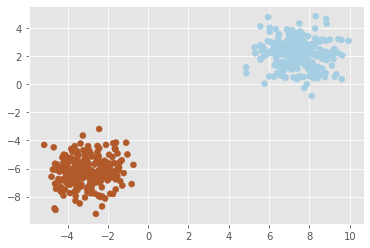

In [ ]:
# Generate and plot the "blobs" dataset.
X_blobs, y_blobs = sklearn.datasets.make_blobs(500, centers=2)
axis = visualize_classification_data(X_blobs, y_blobs)
plt.show()

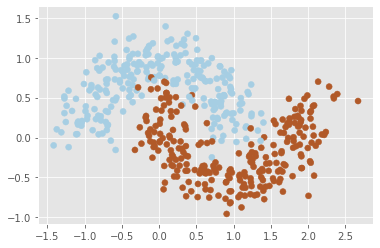

In [ ]:
# Generate and plot the "moons" dataset.
X_moons, y_moons = sklearn.datasets.make_moons(500, noise=0.2)
axis = visualize_classification_data(X_moons, y_moons)
plt.show()

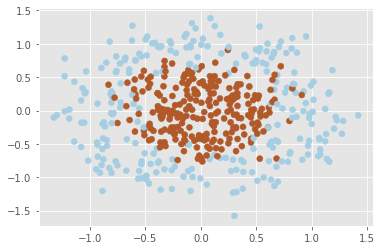

In [ ]:
# Generate and plot the "circles" dataset.
X_circles, y_circles = sklearn.datasets.make_circles(500, noise=0.2, factor=0.4)
axis = visualize_classification_data(X_circles, y_circles)
plt.show()

In [ ]:
datasets = [(X_blobs, y_blobs), (X_moons, y_moons), (X_circles, y_circles)]

Now, you as a human probably would have no trouble noticing the patterns in the above data and would quite easily be able to tell which class a new data point falls under; however, the task is a bit more complex for a machine.

### Objective Functions
As with regression, there needs to be some metric of how bad our model is doing so that the model can work towards minimizing that metric. Every model will typically have a different objective function, but they all revolve around the same concept: penalize the model when it produces an incorrect classification for a data point.

### Nearest Neighbours
One of the simplest classification methods is the $k$-Nearest Neighbours algorithm. It is so simple, that there is actually no training involved.

The $k$-Nearest Neighbours algorithm looks at the $k$ nearest data points in our data set to the one queried and simply predicts a class that agrees with the plurality of those $k$ neighbours.

In lower dimensions, the $k$-Nearest Neighbours algorithm tends to perform quite nicely; however, scalability to higher dimensions and larger datasets (where most useful data is) is quite a large issue since it is so inefficient.

We will experiment with the `sklearn.neighbors.KNeighborsClassifier` here, so look up the Scikit Learn documentation for that to follow along.

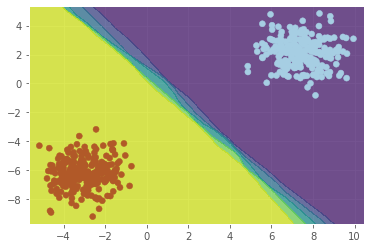

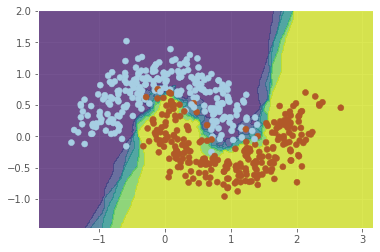

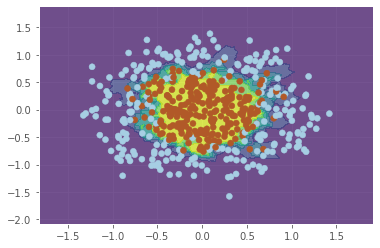

In [ ]:
# Plot predictions on each dataset.
for X, y in datasets:
  # Construct and fit the kNN classifier.
  # Use `sklearn.neighbors.KNeighborsClassifier` with `n_neighbors=5`.
  # Call `knn_classifier.fit` on the data afterwards.
  knn_classifier = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)  # TODO
  knn_classifier.fit(X, y)  # TODO

  # Visualize the classifier.
  axis = visualize_classifier(knn_classifier, X)
  axis = visualize_classification_data(X, y, axis=axis)
  plt.show()


Doesn't look half-bad! Try playing around with the `n_neighbors` value (which is the $k$ in $k$-NN)!

There are a bunch of more complex parameters in the classifier as provided by Scikit Learn, feel free to play around with those, but as of right now you do not really need to know what they do.

### Decision Trees
Another conceptually simple, but deceptively complex, classification method relies on a concept called "decision trees".

Decision trees essentially model a flow chart, where each at each step we ask a certain question about the data point. You can manually construct decision trees for simple tasks, but we can also automatically learn which questions are good to ask.

For example, consider trying to classify fruits depending on their mass, colour, and size. We might start off by asking "is the mass of the fruit greater than 1kg?", if yes then we know it is a larger fruit, perhaps a melon, otherwise we know it is a smaller fruit, perhaps an orange or an apple. If it turns out it was lighter than 1kg, we can ask follow up questions like "is the fruit red?" and make decisions now based on the fact that the fruit is lighter than 1kg but is also red.

Decision trees can get arbitrarily complex, and learning which questions are the best to ask relies on understanding which questions reduce uncertainty about the class of the data point. This deviates slightly from the "objective function" approach we have been taking, but is in similar spirit.

In our case, we will restrict the number of questions to ask on each data point to 4, in other words we will have a maximum tree depth of 4.

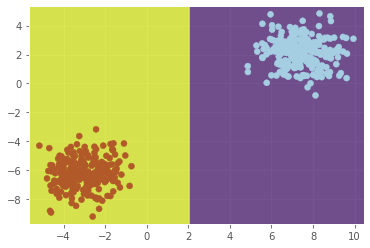

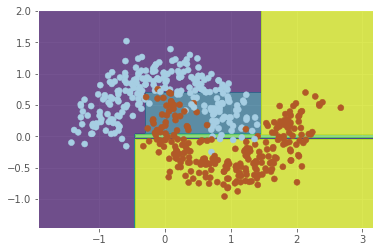

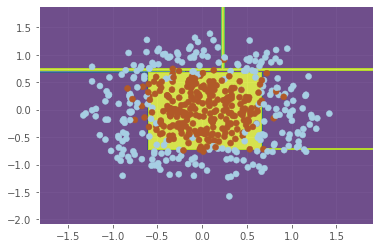

In [ ]:
# Plot predictions on each dataset.
for X, y in datasets:
  # Construct and fit the decision tree classifier.
  # Use `sklearn.tree.DecisionTreeClassifier` with `max_depth=4`.
  # Call `dt_classifier.fit` on the data afterwards.
  dt_classifier = sklearn.tree.DecisionTreeClassifier(max_depth=4)  # TODO
  dt_classifier.fit(X, y)  # TODO

  # Visualize the classifier.
  axis = visualize_classifier(dt_classifier, X)
  axis = visualize_classification_data(X, y, axis=axis)
  plt.show()


We can see that the decision trees produce some pretty simple decision boundaries, but they work decently well, especially considering that we restricted the sizes of the trees.

One advantage of using decision trees, is that they produce somewhat interpretable algorithms; that is, their flowchart can be understood logically rather than just relying on weights that have been learned.

In this case, we can actually look at the decision tree flow chart since we restricted the size of the tree.

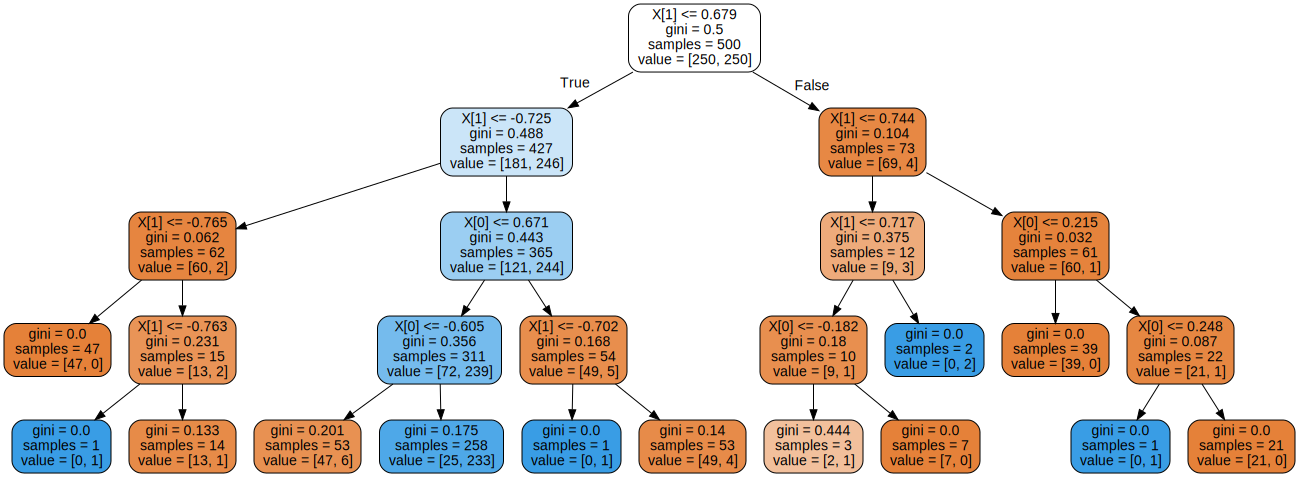

In [ ]:
# Visualize decision tree classifier
graphviz.Source(sklearn.tree.export_graphviz(dt_classifier, filled=True, rounded=True))

### Linear Discriminant Analysis
TODO

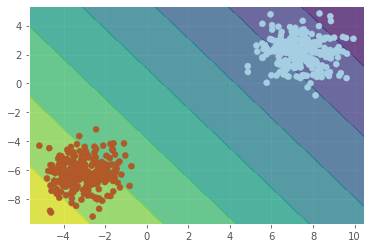

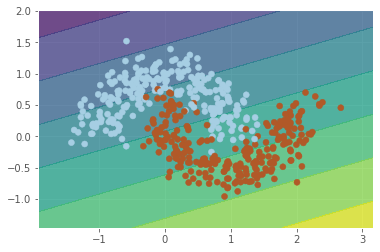

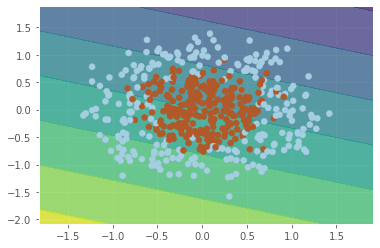

In [ ]:
# Plot predictions on each dataset.
for X, y in datasets:
  # Construct and fit the decision tree classifier.
  # Use `sklearn.discriminant_analysis.LinearDiscriminantAnalysis`.
  # Call `lda_classifier.fit` on the data afterwards.
  lda_classifier = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()  # TODO
  lda_classifier.fit(X, y)  # TODO

  # Visualize the classifier.
  axis = visualize_classifier(lda_classifier, X)
  axis = visualize_classification_data(X, y, axis=axis)
  plt.show()

### SVM
Support-Vector Machines, more commonly known as SVMs, are a class of machine learning models that attempt to generate decision boundaries in the space of data that separate differently-classed data points by as large a distance as possible.

SVMs can typically have any "kernel" function, i.e. the generic "shape" of their decision boundary. A simple kernel function might be a simple linear function, but that means our SVM will only ever have a linear decision boundary, which doesn't work well for a lot of our data.

Checking the SciPy documentation we notice that the default kernel function is "rbf" which stands for Radial Basis Function. It isn't very important what this function does, but it is highly non-linear and has a large variety of different boundary shapes and so it is quite useful in practice.

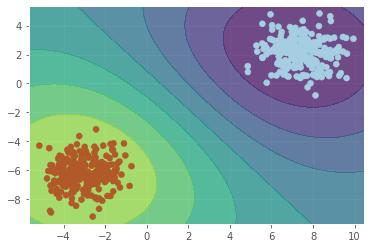

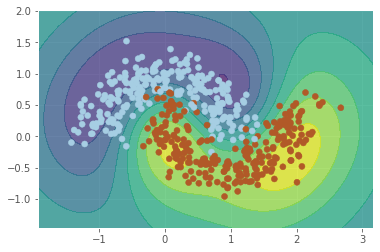

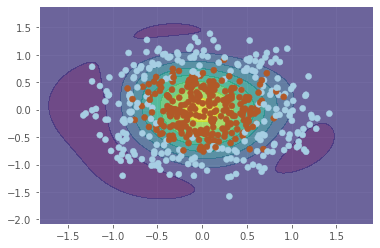

In [ ]:
# Plot predictions on each dataset.
for X, y in datasets:
  # Construct and fit the support-vector machine classifier.
  # Use `sklearn.svm.SVC`.
  # Call `svm_classifier.fit` on the data afterwards.
  svm_classifier = sklearn.svm.SVC()  # TODO
  svm_classifier.fit(X, y)  # TODO

  # Visualize the classifier.
  axis = visualize_classifier(svm_classifier, X)
  axis = visualize_classification_data(X, y, axis=axis)
  plt.show()

### Logistic Regression
Let us talk about a technique that serves as the basis for many more complex classification methods and tends to scale up much better that previously mentioned techniques.

This technique, as you might have guessed from the name, is quite related to linear regression, although it is a classification technique.

Logistic regression, despite the name, is a classification technique which gets its name from the fact that it is based on a regression method. Particularly, we treat the class labels somewhat as a probability between $0$ and $1$ and we try to regress in order to predict the probability of that class being the true class. In this sense, the task is a regression task, but it forms the basis of a classification method.


#### Logistic Function
In order to properly regress between $0$ and $1$ we need to somehow bound the output of our regression models between $0$ and $1$. We can do this in a number of ways, such as simply clipping the values; however, a very popular techniques employs the logistic or sigmoid function:
$$\sigma(x) := \frac{1}{1 + e^{x}}$$
This function should seem a bit familiar, because we implemented it previously in the NumPy section! Let's see how it looks.

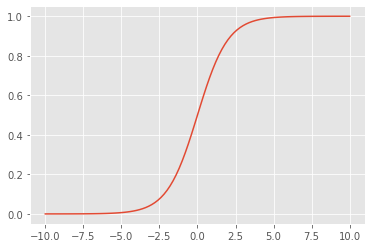

In [ ]:
# Visualize the sigmoid function on the interval [-10, 10].
axis = visualize_func(sigmoid, domain=(-10, 10))
plt.show()

Notice how the function is bounded in $[0, 1]$ for all values of $x$! This is critical for how logistic regression works.

Logistic regression is simply linear regression with the sigmoid function applied at the end. The output of the "regression" model is then interpreted as how confident the model is that a data point is of each class.

#### Model

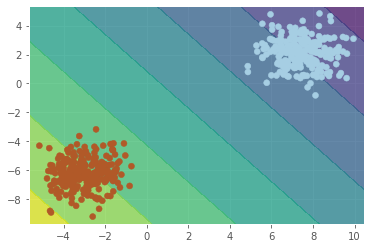

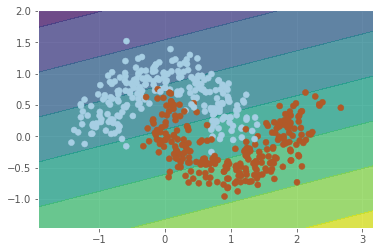

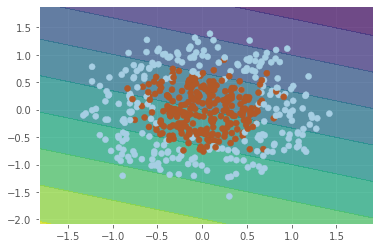

In [ ]:
# Plot predictions on each dataset.
for X, y in datasets:
  # Construct and fit the logistic regression model.
  # Use `sklearn.linear_model.LogisticRegression`.
  # Call `lr_classifier.fit` on the data afterwards.
  lr_classifier = sklearn.linear_model.LogisticRegression()  # TODO
  lr_classifier.fit(X, y)  # TODO

  # Visualize the classifier.
  axis = visualize_classifier(lr_classifier, X)
  axis = visualize_classification_data(X, y, axis=axis)
  plt.show()

Hmm, doesn't look as great. There is a clear distinction between the two clusters in the first plot; however, the rest seem kind of bad. Also, the boundaries seem to be very linear compared to $k$-NN where they were very non-linear, what's going on?

Remember, logistic regression builds off of linear regression directly! So the only data a vanilla logistic regression classifier will be able to classify correctly is going to be data that has its classes linearly separable (i.e. we can draw a line between the data to separate the classes). This is the case for the first example, but definitely not the rest.

Do not let this discourage you, though! The concepts behind logistic regression, and particularly the sigmoid function, form the basis for much better classification methods.



#### MLP Classifier
This section just serves as a demo for what can be achieved with the principles of logistic regression. We still have not talked about what MLPs are or how they work, so do not worry about it.

MLP classifiers are multi-layer perceptron classifiers (essentially neural networks) that build off of the concept of logistic regression.

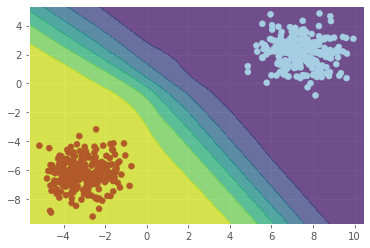

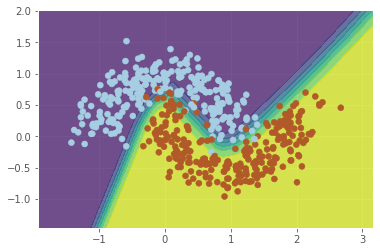

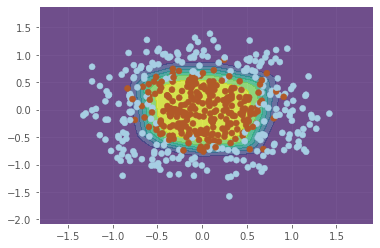

In [ ]:
# Plot predictions on each dataset.
for X, y in datasets:
  # Construct and fit the MLP classifier.
  mlp_classifier = sklearn.neural_network.MLPClassifier(max_iter=1000)
  mlp_classifier.fit(X, y)

  # Visualize the classifier.
  axis = visualize_classifier(mlp_classifier, X)
  axis = visualize_classification_data(X, y, axis=axis)
  plt.show()

Looks a lot nicer, eh? We'll figure out how to make things that work this well pretty soon.

### Going Further

There are a whole lot of classification methods out there, each with its virtues and vices. Try playing around with some more classification models provided by Scikit Learn to get the hang of stuff!

All of the concepts introduced here can be generalized to higher dimensions, and libraries such as Scikit Learn make that quite easy. Just make sure to pay attention to the data shapes going in and out of the models.

## 2D Clustering and Unsupervised Learning
The classes of your data points aren't necessarily given! Consider trying to detect whether or not someone is clenching their jaw by way of an EG. You might have someone asking someone to clench and unclench their jaw while recording their clenching state, but it would probably be a lot easier to just collect the EG data without labelling it.

Tasks without associated labels are called unsupervised tasks, and they aren't always classification tasks.

In this section, we will approach unsupervised learning from the classification sense in one particular situation: clustering. Clustering involves trying to assign common associations to pieces of datat by way of their associations in high-dimensional space.

Consider the following example of unclassified data. Although the classes aren't given, if given a new point (visualized in blue) we can make a good prediction on which "cluster" of data this new point belongs to.

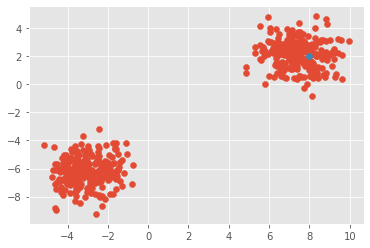

In [ ]:
X, y = datasets[0]
axis = visualize_clustering_data(X)
axis = visualize_clustering_data([[8, 2]], axis=axis)
plt.show()

Unsupervised learning can be a bit tricky, though. Consider this next example and try to say which cluster the new point (visualized in blue) belongs to. If you already knew that this was the "two moons" configuration we have seen before, you might be able to guess; however, our unsupervised algorithms don't have access to the labelled data and that makes their job a lot more difficult.

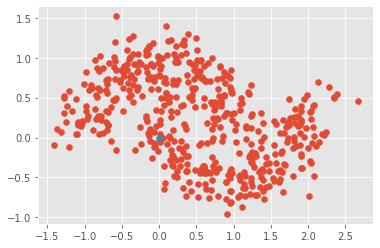

In [ ]:
X, y = datasets[1]
axis = visualize_clustering_data(X)
axis = visualize_clustering_data([[0, 0]], axis=axis)
plt.show()

Clustering algorithms attempt to automate this process. The most basic clustering algorithm is based on clustering by how far away points are, similar to how k-NN does classification.

### k-Means
k-means is a simple but deceptively powerful clustering algorithm. Given a parameter `k` it attempts to assign the points into `k` classes that minimize the variance of the points within those classes.

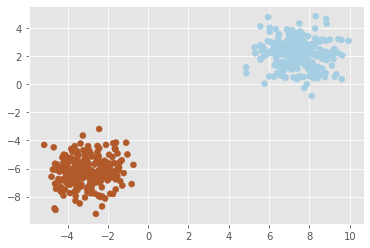

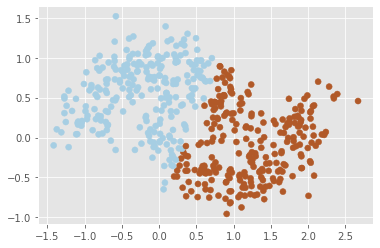

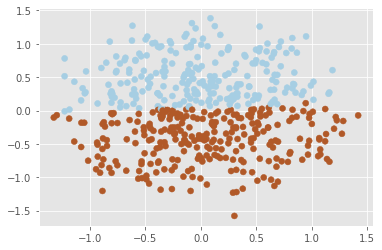

In [ ]:
# Plot predictions on each dataset.
for X, y in datasets:
  # Construct and fit the k-means clusterer.
  # Use `sklearn.cluster.KMeans` with `n_clusters=2`.
  # Call `kmeans_clusterer.fit` on the data afterwards.
  kmeans_clusterer = sklearn.cluster.KMeans(n_clusters=2)  # TODO
  kmeans_clusterer.fit(X, y)  # TODO

  # Visualize the classifier.
  axis = visualize_clusterer(kmeans_clusterer, X)
  plt.show()

Unsupervised learning tends to be a lot harder than its supervised counterpart. We will investigate more effective techniques for unsupervised learning down the road.

## Dimensionality Reduction

So far, we have mostly been working with one- or two-dimensional input data. One-dimensional in the case of linear regression (recall that our functions were maps from the reals to the reals) and two-dimentional for classification (our data was plotted in 2D and we represented the class by color).

Most real-world data is not so low-dimensional, and every machine learning library worth its salt takes that into account and supports their algorithms, typically, on an input dimension of arbitrary size. However, with higher-dimensional data comes the _curse of dimensionality_, which highlights that as the dimensionality of data grows, standard algorithms tend to take exponentially longer to run.

There are many ways that people have tried to get around this curse of dimensionality, but one that has proven to be particularly successful is this idea of "dimensionality reduction", where we take high-dimensional data to a lower-dimensional space and then apply our algorithms.

The intuition behind this is that a lot of the time, even if data is high-dimensional, it can be represented more compactly (or compressed) into a lower-dimensional space. The degree to which that compression loses information contained within that data depends on the nature of the data and the technique of reduction.

Many modern machine learning systems will have components that learn to reduce the dimensionality of data according to dynamically learned metrics that optimize for preservation of information that is important to the task at hand. We will begin by considering some rudimentary dimensionality reduction techniques that underpin more modern systems.

### Principal Component Analysis
Principal component analysis, commonly referenced as PCA, is a rudimentary dimentionality reduction technique. Intuitively, if reducing a `D` dimensional dataset to a `K` dimensional dataset, it attempts to find the "most important" `K` "directions" of those `D` dimensions in the sense that those `K` directions capture the largest amount of variablility or information in the dataset out of all `K` directions.

This is a bit hard to imagine sometimes, so let's show off a couple concrete examples that will be able to do by hand.

Typically dimentionality reduction techniques are only applied to very high-dimentional data; however, since high-dimentional data is difficult to conceptualize, we use a toy 2D dataset. Consider the following simple linear dataset, we generate and plot it below.

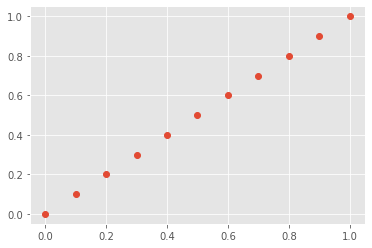

In [ ]:
# Generate a $y = x$ dataset of 11 points equally spaced in [0, 1] and plot it.
xs = np.linspace(0, 1, 11)
ys = np.linspace(0, 1, 11)
plt.plot(xs, ys, "o")
plt.show()

Based on our intuition of how this dataset looks, and the function it comes from, we wonder if we need both dimentions of this data (`x` and `y` components) in order to represent the information contained within this dataset.

Since we already know the data comes from the function `f(x) = x` we can pretty certainly answer the previous question as "no", as we can always generate the `y` from the `x` using the function; however, for more complicated datasets we would not have such prior knowledge and neither would our algorithms, so we approach this more systematically.

Based on the intuition of PCA, if we are trying to reduce this 2D dataset to a 1D dataset, we want to find a singular direction that captures as much of the dataset "information" as possible. We can then project that 2D dataset onto the 1D principal component.

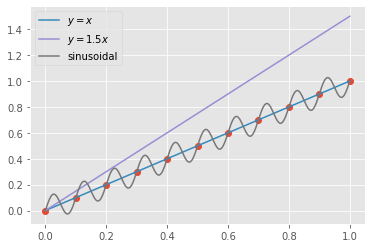

In [ ]:
ax = plt.subplot()
ax.plot(xs, ys, "o")
ax.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), label="$y=x$")
ax.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2) * 1.5, label="$y=1.5x$")
ax.plot(np.linspace(0, 1, 1001), 0.1 * np.sin(20 * np.pi * np.linspace(0, 1, 1001)) + np.linspace(0, 1, 1001), label="sinusoidal")
plt.legend()
plt.show()

In the above diagram, we show three functions each of which somewhat capture the directionality of the data. However, there are some caveats:

1. PCA is a linear method, so the sinusoidal function does not work in this case.
2. Even though $y=1.5x$ is roughly in the correct direction, it might lose some information about the spacing of the data if you imagine projecting it.
3. Works perfectly in this case, it captures the exact direction of the data, but things are not so simple in practice.

Below we explore using PCA more practically.

First we construct our dataset and visualize it. Notice how the data is split up into three distinct classes, let's see if we can make out those classes in the PCA reduced-dimentionality example as well.

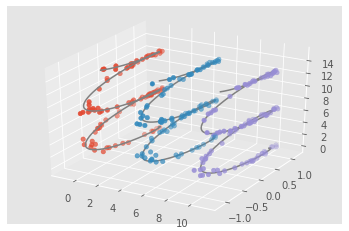

In [ ]:
ax = plt.axes(projection='3d')
n_samples = 100

data = []
for i in range(3):
  zline = np.linspace(0, 15, 1000)
  xline = 5 * i + np.sin(zline)
  yline = np.cos(zline)
  ax.plot3D(xline, yline, zline, 'gray')

  zdata = 15 * np.random.random(n_samples)
  xdata = 5 * i + np.sin(zdata) + 0.1 * np.random.randn(n_samples)
  ydata = np.cos(zdata) + 0.1 * np.random.randn(n_samples)
  ax.scatter3D(xdata, ydata, zdata)

  data.append(np.stack([xdata, ydata, zdata], axis=1))
data = np.array(data)

[]

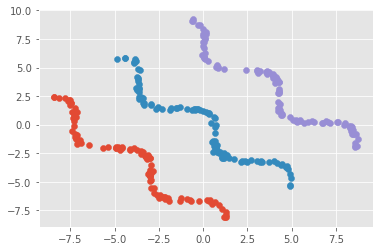

In [ ]:
  # Construct and fit the PCA reducer.
  # Use `sklearn.svm.SVC` with `n_components=2`.
  # Call `pca_reducer.fit` on the data afterwards.
  pca_reducer = sklearn.decomposition.PCA(n_components=2)  # TODO

  # Fitting this is a bit different, so we do it for you.
  X = np.stack([data[:, :, 0].flatten(), data[:, :, 1].flatten(), data[:, :, 2].flatten()], axis=1)
  pca_reducer.fit(X)

  # Visualize each set of the data that has been reduced.
  ax = visualize_clustering_data(pca_reducer.transform(data[0]))
  ax = visualize_clustering_data(pca_reducer.transform(data[1]), axis=ax)
  ax = visualize_clustering_data(pca_reducer.transform(data[2]), axis=ax)
  plt.plot()

It seems like our instance of PCA did something weird and unrolled the data in some way, but the key thing is that it keeps a lot of the underlying information and we can clearly make out the grouping, even if we didn't have the labels.

Sometimes, we can throw away dimentions ourselves, in the case below we throw away the elevation dimention and we see that we keep a lot of the information, but most likely not as much as PCA. For example, PCA still keeps some elevation information in this case.


[]

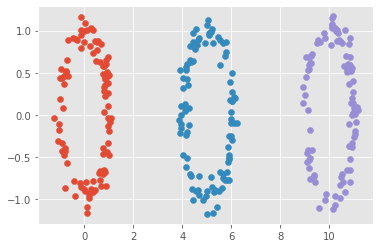

In [ ]:
  ax = visualize_clustering_data(data[0, 1:])
  ax = visualize_clustering_data(data[1, 1:], axis=ax)
  ax = visualize_clustering_data(data[2, 1:], axis=ax)
  plt.plot()

This same concept applies to larger datasets, ones with thousands of dimentions. By reducing the dimentionality of the data we can make training using the methods previously introduced in this notebook easier and more tractable, sometimes with very little degradation in performance when the data has superflouous dimentions (that aren't always clear to an observer).

PCA is one of many different dimentionality reduction techniques, but they all follow the same principles introduced here.

## Ensembling
What's better than one machine learning model producing decisions? Multiple machine learning models voting on a decision to be made. The concept of ensembling formalizes this idea.

By leveraging multiple machine learning models that are decorrelated (this is important, we'll get back to it later) to produce predictions, rather than a single one, we can improve the performance of our systems. Ensembling methods are something of "meta-algorithms" that take multiple machine learning models and combine them in some way to use all their knowledge to produce a collective decision.

However, there is one important consideration: if all your machine learning models produce the same predictions or very similar predictions, then your ensembles are just an echo-chamber of the same decision. For that reason, we prefer to combine machine learning models that aren't trained in the same way or on the same data, or even sometimes using the same technique.

There are three major types of ensembling: bagging, boosting, and stacking.
* Bagging stands for bootstrap aggregation. Bagging methods train multiple of the same model on different subsets of a dataset in order to reduce the variance of the resulting system.
* Boosting methods train a set of weak classifiers to turn into one strong classifier by combining and training them in certain ways.
* Stacking is a very general term that refers to using a meta-algorithm to learn how to combine different machine learning models to produce the best results.

We now investigate some common ensemble models.

### Random Forest Classifiers
Random forests are arguablly the most famous ensemble classifier. A random forest classifier is an ensembling method that utilizes bagging to train multiple decision tree classifiers and combines them to classify. We previously discussed how a decision tree works in the 2D Classification section.

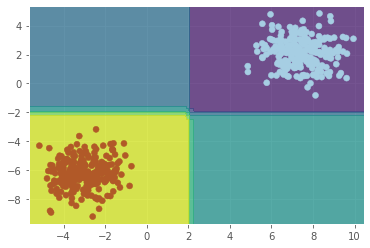

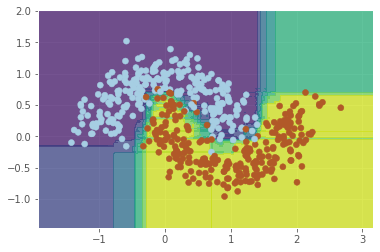

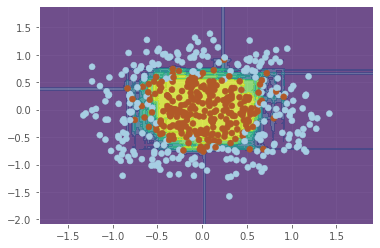

In [ ]:
# Plot predictions on each dataset.
for X, y in datasets:
  # Construct and fit the random forest classifier.
  # Use `sklearn.ensemble.RandomForestClassifier`.
  # Call `rf_classifier.fit` on the data afterwards.
  rf_classifier = sklearn.ensemble.RandomForestClassifier()  # TODO
  rf_classifier.fit(X, y)  # TODO

  # Visualize the classifier.
  axis = visualize_classifier(rf_classifier, X)
  axis = visualize_classification_data(X, y, axis=axis)
  plt.show()

### AdaBoost Classifier
An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases. AdaBoost is a boosting method.

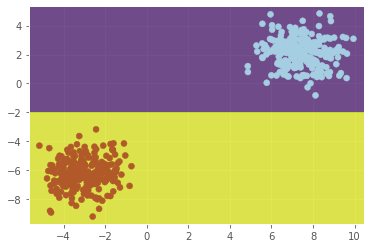

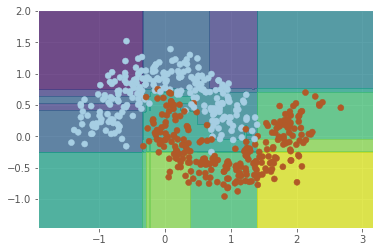

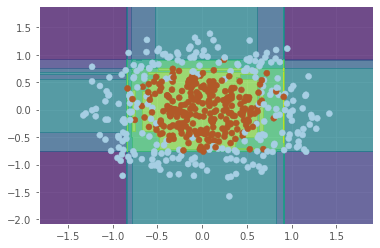

In [ ]:
# Plot predictions on each dataset.
for X, y in datasets:
  # Construct and fit the AdaBoost classifier.
  # Use `sklearn.ensemble.AdaBoostClassifier`.
  # Call `ada_classifier.fit` on the data afterwards.
  ada_classifier = sklearn.ensemble.AdaBoostClassifier()  # TODO
  ada_classifier.fit(X, y)  # TODO

  # Visualize the classifier.
  axis = visualize_classifier(ada_classifier, X)
  axis = visualize_classification_data(X, y, axis=axis)
  plt.show()

### Stacking Classifier
Stack of estimators with a final classifier.

Stacked generalization consists in stacking the output of individual estimator and use a classifier to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.

WARNING: this might take a little while to run.

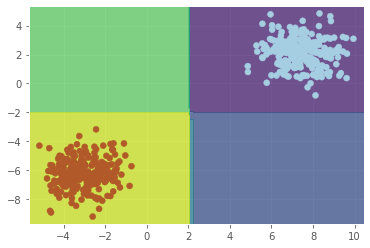

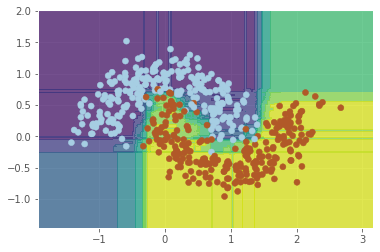

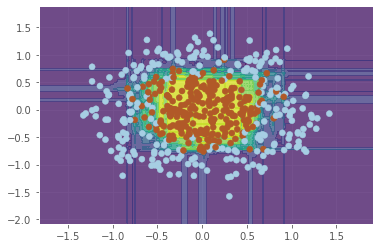

In [ ]:
# Plot predictions on each dataset.
for X, y in datasets:
  # Construct and fit the decision tree classifier.
  # Use `sklearn.ensemble.RandomForestClassifier`.
  # Call `rf_classifier.fit` on the data afterwards.
  rf_classifier = sklearn.ensemble.RandomForestClassifier()  # TODO
  rf_classifier.fit(X, y)  # TODO

  # Construct and fit the AdaBoost classifier.
  # Use `sklearn.ensemble.AdaBoostClassifier`.
  # Call `ada_classifier.fit` on the data afterwards.
  ada_classifier = sklearn.ensemble.AdaBoostClassifier()  # TODO
  ada_classifier.fit(X, y)  # TODO

  # Create a list of estimators that should be stacked together.
  # List must be of the form List[Tuple[str, Estimator]], i.e.
  # a list of tuples of name and then the classifier.
  estimators = [("Random Forest", rf_classifier), ("AdaBoost", ada_classifier)]  # TODO

  # Construct and fit the stacking classifier.
  # Use `sklearn.ensemble.StackingClassifier`.
  # Call `stacking_classifier.fit` on the data afterwards.
  stacking_classifier = sklearn.ensemble.StackingClassifier(estimators)  # TODO
  stacking_classifier.fit(X, y)  # TODO

  # Visualize the classifier.
  axis = visualize_classifier(stacking_classifier, X)
  axis = visualize_classification_data(X, y, axis=axis)
  plt.show()

## Pipelining
Now that we introduced all these different machine learning techniques, and we saw how we can combine them "in parallel" to improve performance, let's see how we can connect them "in series" to produce some interesting solutions.

Let's revisit our "circles" dataset to showcase an interesting application of pipelining.

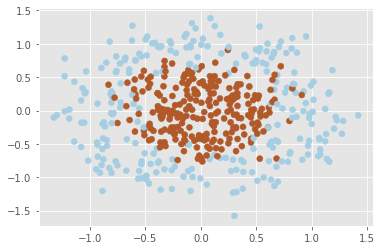

In [ ]:
X, y = datasets[2]
axis = visualize_classification_data(X, y)
plt.show()

This type of dataset can be quite hard to classify using a linear classifier because the data is inherently non-linear! 

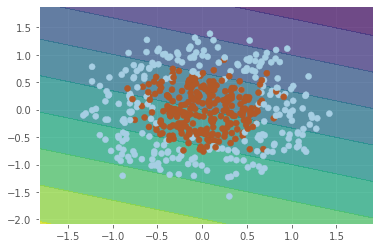

In [ ]:
lin_classifier = sklearn.linear_model.LogisticRegression()
lin_classifier.fit(X, y)

axis = visualize_classifier(lin_classifier, X)
axis = visualize_classification_data(X, y, axis=axis)
plt.show()

But visually inspecting this dataset, we might consider something like *making* it linearly separable by using some sort of inversible transformation. In this case we are going to be using a coordinate transformation from cartesian coordinates to polar coordinates.

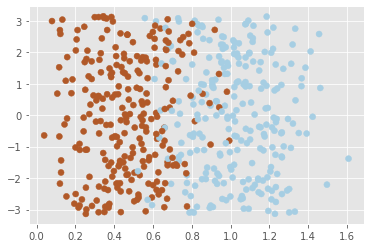

In [ ]:
def cart2pol(X):
    rhos = np.sqrt(X[:, 0] ** 2 + X[:, 1] ** 2)
    phis = np.arctan2(X[:, 1], X[:, 0])
    return np.stack([rhos, phis]).T

X_ = cart2pol(X)
axis = visualize_classification_data(X_, y)
plt.show()

With the above transformation, we can then apply a linear method of classification and end up with something that might work!

This process of applying multiple different techniques in succession is called "pipelining", and Scikit Learn has a class to do just that very easily. It combines all the training, evaluation, and basically everything else into one object that we can use.

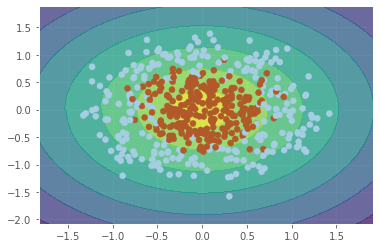

In [ ]:
# Transformation from cartesian to polar coordinates.
transform = sklearn.preprocessing.FunctionTransformer(cart2pol)
# Logistic regression classifier.
classifier = sklearn.linear_model.LogisticRegression()

# Construct and fit the pipeline
pipeline = sklearn.pipeline.make_pipeline(transform, classifier)
pipeline.fit(X, y)

axis = visualize_classifier(pipeline, X)
axis = visualize_classification_data(X, y, axis=axis)
plt.show()

The possibilities with pipelining are endless. We do not need to have a transformation followed by a classification, and we definitely do not need to have a hand-crafted technique for preprocessing.

We can combine different complex machine learning techniques into this series that utilizes some of our insights as humans observing the data and converts it into structure in our machine learning models.

## Neural Networks